In [10]:
from nltk.corpus import wordnet as wn
import networkx as nx
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Defining Highest Discriminating Node
I based my definition on some sentences from [this assignment](http://www.cs.princeton.edu/courses/archive/spring07/cos226/assignments/wordnet.html)

* The WordNet graph is **directed and acyclic**, though not necessarily a tree since each synset can have several hypernyms.
* each **vertex v** is an integer that represents a synset
* each **directed edge** v -> w represents that w is a hypernym of v. 
* WordNet graph provides a mapping between a **lemma and pos** combination and the vertices (i.d synsets) it can mean

given a lemma $l$ and a pos $p$:
* let $M$ be the set of vertices that the combination of $l$ and $p$ can refer to according to WordNet
* let $M_i$ be an element of $M$
* let $C$ be the set of elements in $M$ that are not $M_i$

* given two vertices $v$ and $w$, $ancestor\_vertex$ is the lowest (i.e. deepest) vertex that has both v and w as descendants

* let $A$ be the lowest $ancestor\_vertex$ from all ancestor vertices between $M_i$ and all elements in $C$
* let $HDN$ be the highest vertex in the path from $M_i$ to $A$

In [12]:
def synset2identifier(synset, wn_version):
    """
    return synset identifier of 
    nltk.corpus.reader.wordnet.Synset instance

    :param nltk.corpus.reader.wordnet.Synset synset: a wordnet synset
    :param str wn_version: supported: '171 | 21 | 30'

    :rtype: str
    :return: eng-VERSION-OFFSET-POS (n | v | r | a)
    e.g. 
    """
    offset = str(synset.offset())
    offset_8_char = offset.zfill(8)

    pos = synset.pos()
    if pos == 'j':
        pos = 'a'

    identifier = 'eng-{wn_version}-{offset_8_char}-{pos}'.format_map(locals())

    return identifier


def synsets_graph_info(wn_instance, wn_version, lemma, pos):
    """
    extract:
    1. hyponym under lowest least common subsumer

    :param nltk.corpus.reader.wordnet.WordNetCorpusReader wn_instance: instance
    of nltk.corpus.reader.wordnet.WordNetCorpusReader
    :param str wn_version: supported: '171' | '21' | '30'
    :param str lemma: a lemma
    :param str pos: a pos

    :rtype: dict
    :return: mapping synset_id 
        -> 'under_lcs' -> under_lcs identifier
        -> 'path_to_under_lcs' -> [sy1_iden, sy2_iden, sy3_iden, ...]
    """
    sy_id2under_lcs_info = dict()

    synsets = wn_instance.synsets(lemma, pos=pos)

    if len(synsets) == 1:
        target_sy_iden = synset2identifier(synsets[0], wn_version)
        sy_id2under_lcs_info[target_sy_iden] = {'under_lcs': None,
                                                'path_to_under_lcs': []}
        return sy_id2under_lcs_info

    for sy1 in synsets:

        target_sy_iden = synset2identifier(sy1, wn_version)

        min_path_distance = 100
        closest_lcs = None

        for sy2 in synsets:
            if sy1 != sy2:
                lcs_s = sy1.lowest_common_hypernyms(sy2)
                lcs = lcs_s[0]

                path_distance = sy1.shortest_path_distance(lcs)

                if path_distance < min_path_distance:
                    closest_lcs = lcs
                    min_path_distance = path_distance

        under_lcs = None
        for hypernym_path in sy1.hypernym_paths():
            for first, second in zip(hypernym_path, hypernym_path[1:]):
                if first == closest_lcs:
                    under_lcs = second

                    index_under_lcs = hypernym_path.index(under_lcs)
                    path_to_under_lcs = hypernym_path[index_under_lcs + 1:-1]

                    under_lcs_iden = synset2identifier(under_lcs, wn_version)
                    path_to_under_lcs_idens = [synset2identifier(synset, wn_version)
                                               for synset in path_to_under_lcs]

                    sy_id2under_lcs_info[target_sy_iden] = {'under_lcs': under_lcs_iden,
                                                            'under_lcs_obj' : under_lcs,
                                                            'path_to_under_lcs': path_to_under_lcs_idens}

    return sy_id2under_lcs_info

# Implemented so far

number of senses 5

CANDIDATE SYNSET Synset('horse.n.01') solid-hoofed herbivorous quadruped domesticated since prehistoric times
HDN Synset('living_thing.n.01') a living (or once living) entity

CANDIDATE SYNSET Synset('horse.n.02') a padded gymnastic apparatus on legs
HDN Synset('sports_equipment.n.01') equipment needed to participate in a particular sport

CANDIDATE SYNSET Synset('cavalry.n.01') troops trained to fight on horseback
HDN Synset('abstraction.n.06') a general concept formed by extracting common features from specific examples

CANDIDATE SYNSET Synset('sawhorse.n.01') a framework for holding wood that is being sawed
HDN Synset('structure.n.01') a thing constructed; a complex entity constructed of many parts

CANDIDATE SYNSET Synset('knight.n.02') a chessman shaped to resemble the head of a horse; can move two squares horizontally and one vertically (or vice versa)
HDN Synset('game_equipment.n.01') equipment or apparatus used in playing a game


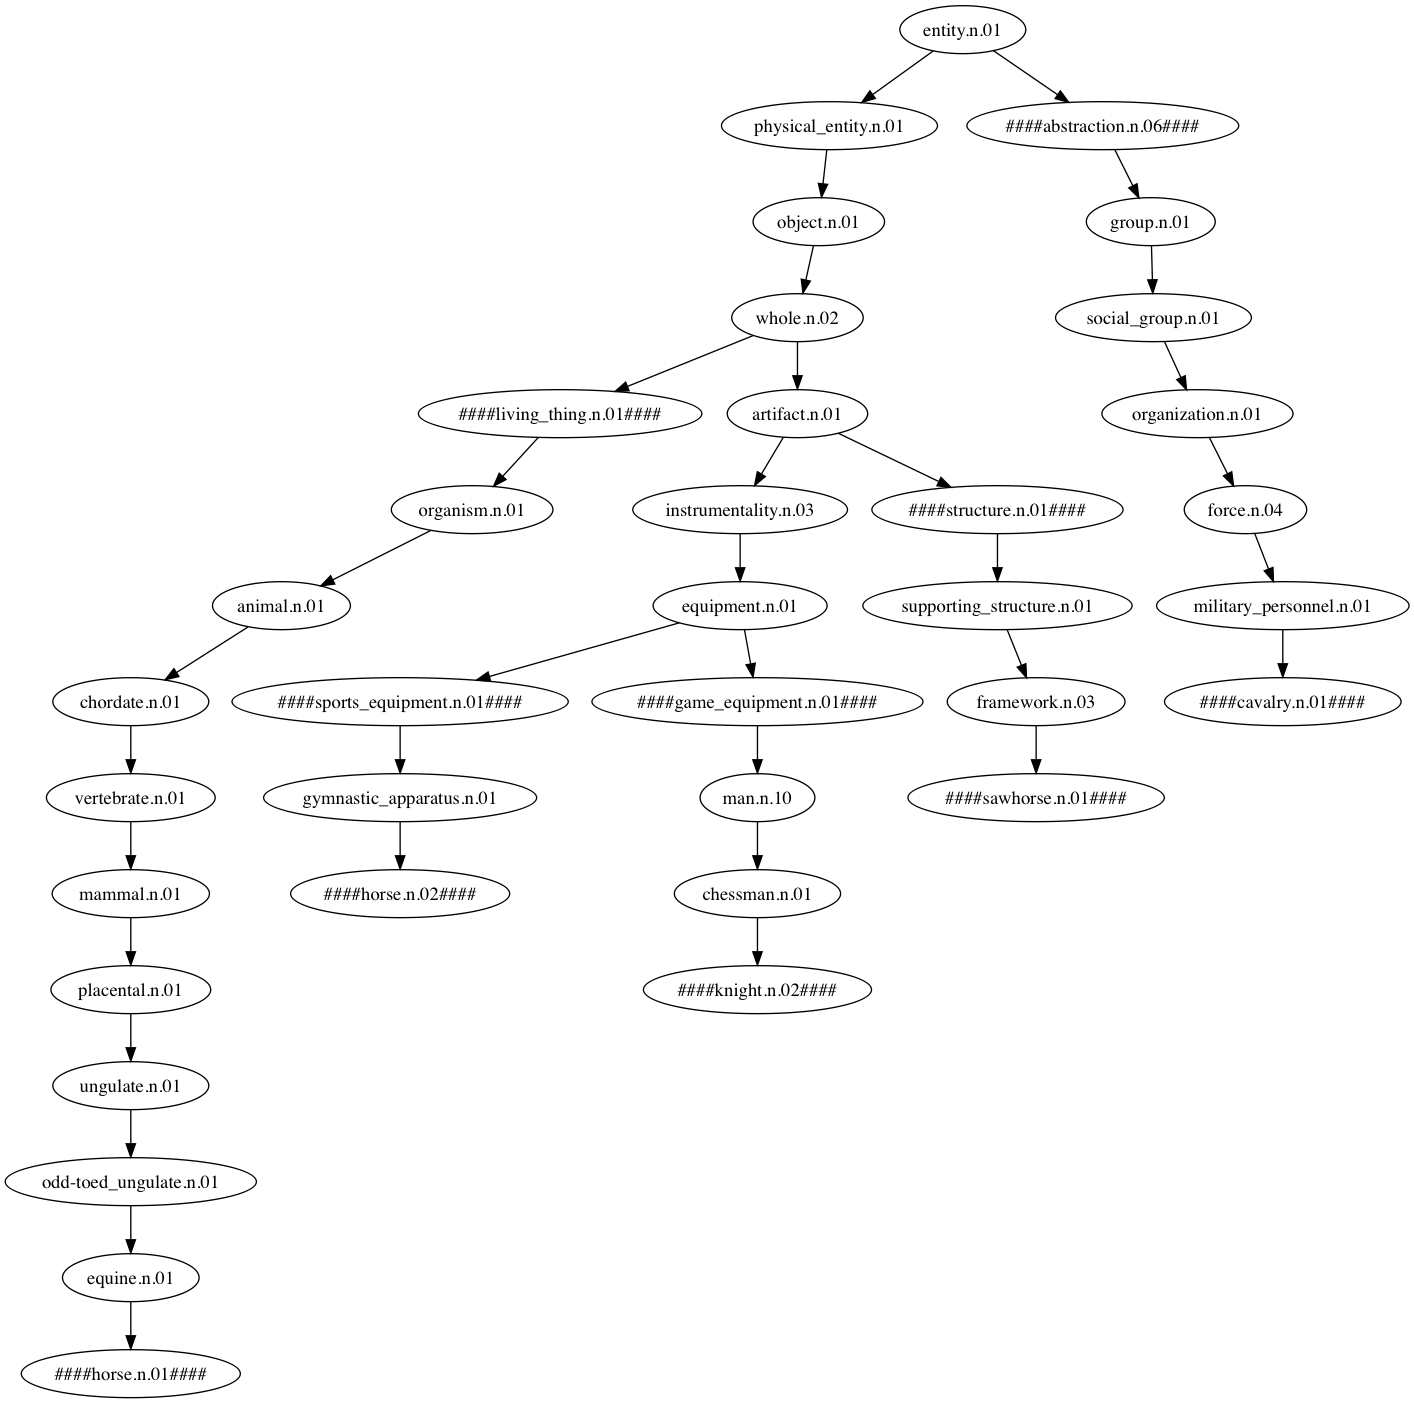

In [13]:
lemma = 'horse'
pos = 'n'
synsets = wn.synsets(lemma, pos=pos)
graph_info = synsets_graph_info(wn, '30', lemma, pos)

print('number of senses', len(synsets))
add_definitions = False

edges = []
for synset in synsets:
    base_synset_iden = synset2identifier(synset, '30')
    hdn = graph_info[base_synset_iden]['under_lcs']
    hdn_obj = graph_info[base_synset_iden]['under_lcs_obj']
    print()
    print('CANDIDATE SYNSET', synset, synset.definition())
    print('HDN', hdn_obj, hdn_obj.definition())
    
    
    cand_label = synset.name()
        
    for path in synset.hypernym_paths():
        if len(path) >= 2:
            for hypernym, hyponym in zip(path[:-1], path[1:]):
                
                hyper_label = hypernym.name()
                hyper_iden = synset2identifier(hypernym, '30')
                hypo_label = hyponym.name()
                hypo_iden = synset2identifier(hyponym, '30')
                
                if any([hyper_label == cand_label,
                        hyper_iden == hdn]):
                    hyper_label = '####%s####' % hyper_label
                    
                if any([hypo_label == cand_label,
                        hypo_iden == hdn]):
                    hypo_label = '####%s####' % hypo_label
                    
                hyper_def = ''
                hypo_def = ''
                if add_definitions:
                    hyper_def = ' \\n (%s)' % hypernym.definition()
                    hypo_def = ' \\n (%s)' % hyponym.definition()
                
                hyper_node_label = "{hyper_label}{hyper_def}".format_map(locals())
                hypo_node_label = "{hypo_label}{hypo_def}".format_map(locals())
                
                edges.append((hyper_node_label, hypo_node_label))
                
g = nx.DiGraph()
g.add_edges_from(edges)
p=nx.drawing.nx_pydot.to_pydot(g)
p.write_png('example.png')
display(Image(filename='example.png'))